In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generator

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CIFAR100 is in color (red, green, blue), so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4, kernel_size=4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=2, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?)
    Parameters:
    x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
    y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    return torch.cat([x, y], 1)

def get_one_hot_labels(labels, n_classes):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?)
    Parameters:
    labels: (n_samples, 1) 
    n_classes: a single integer corresponding to the total number of classes in the dataset
    '''
    return F.one_hot(labels, n_classes)

# Training

In [3]:
cifar100_shape = (3, 32, 32)
n_classes = 100
n_epochs = 10000
z_dim = 64
display_step = 500
batch_size = 64
lr = 0.0002
device = 'cuda'

generator_input_dim = z_dim + n_classes

# Classifier

In [4]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan, n_classes, hidden_dim=32):
        super(Classifier, self).__init__()
        self.disc = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.disc(image)
        return class_pred.view(len(class_pred), -1)

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, stride=1),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

def train_generator():
    gen = Generator(generator_input_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    discriminator_input_dim = cifar100_shape[0] + n_classes
    disc = Discriminator(discriminator_input_dim).to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

    criterion = nn.BCEWithLogitsLoss()
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for epoch in range(n_epochs):
        # Dataloader returns the batches and the labels
        for real, labels in dataloader:
            cur_batch_size = len(real)
            # Flatten the batch of real images from the dataset
            real = real.to(device)

            # Convert the labels from the dataloader into one-hot versions of those labels
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, cifar100_shape[1], cifar100_shape[2])

            ### Update discriminator ###
            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
            # Combine the vectors of the noise and the one-hot labels for the generator
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)
            # Combine the vectors of the images and the one-hot labels for the discriminator
            fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            disc_real_pred = disc(real_image_and_labels)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

            ### Update generator ###
            # Zero out the generator gradients
            gen_opt.zero_grad()

            # Pass the discriminator the combination of the fake images and the one-hot labels
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()

            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(fake)
                show_tensor_images(real)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1

def train_classifier():
    criterion = nn.CrossEntropyLoss()
    n_epochs = 10

    validation_dataloader = DataLoader(
        CIFAR100(".", train=False, download=True, transform=transform),
        batch_size=batch_size)

    display_step = 10
    batch_size = 512
    lr = 0.0002
    device = 'cuda'
    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            real = real.to(device)
            labels = labels.to(device)

            ### Update classifier ###
            # Get noise corresponding to the current batch_size
            classifier_opt.zero_grad()
            labels_hat = classifier(real.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            if cur_step % display_step == 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                for val_example, val_label in validation_dataloader:
                    cur_batch_size = len(val_example)
                    num_validation += cur_batch_size
                    val_example = val_example.to(device)
                    val_label = val_label.to(device)
                    labels_hat = classifier(val_example)
                    classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                    classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()

                print(f"Step {cur_step}: "
                        f"Classifier loss: {classifier_val_loss.item() / num_validation}, "
                        f"classifier accuracy: {classifier_correct.item() / num_validation}")
            cur_step += 1

In [6]:
def combine_sample(real, fake, p_real):
    '''
    Function to take a set of real and fake images of the same length (x)
    and produce a combined tensor with length (x) and sampled at the target probability
    Parameters:
        real: a tensor of real images, length (x)
        fake: a tensor of fake images, length (x)
        p_real: the probability the images are sampled from the real set
    '''
    
    make_fake = torch.rand(len(real)) > p_real
    target_images = real.clone()
    target_images[make_fake] = fake[make_fake]

    return target_images

In [7]:
n_test_samples = 9999
test_combination = combine_sample(
    torch.ones(n_test_samples, 1), 
    torch.zeros(n_test_samples, 1), 
    0.3
)
# Check that the shape is right
assert tuple(test_combination.shape) == (n_test_samples, 1)
# Check that the ratio is right
assert torch.abs(test_combination.mean() - 0.3) < 0.05
# Make sure that no mixing happened
assert test_combination.median() < 1e-5

test_combination = combine_sample(
    torch.ones(n_test_samples, 10, 10), 
    torch.zeros(n_test_samples, 10, 10), 
    0.8
)
# Check that the shape is right
assert tuple(test_combination.shape) == (n_test_samples, 10, 10)
# Make sure that no mixing happened
assert torch.abs((test_combination.sum([1, 2]).median()) - 100) < 1e-5

test_reals = torch.arange(n_test_samples)[:, None].float()
test_fakes = torch.zeros(n_test_samples, 1)
test_saved = (test_reals.clone(), test_fakes.clone())
test_combination = combine_sample(test_reals, test_fakes, 0.3)
# Make sure that the sample isn't biased
assert torch.abs((test_combination.mean() - 1500)) < 100
# Make sure no inputs were changed
assert torch.abs(test_saved[0] - test_reals).sum() < 1e-3
assert torch.abs(test_saved[1] - test_fakes).sum() < 1e-3

test_fakes = torch.arange(n_test_samples)[:, None].float()
test_combination = combine_sample(test_reals, test_fakes, 0.3)
# Make sure that the order is maintained
assert torch.abs(test_combination - test_reals).sum() < 1e-4
if torch.cuda.is_available():
    # Check that the solution matches the input device
    assert str(combine_sample(
        torch.ones(n_test_samples, 10, 10).cuda(), 
        torch.zeros(n_test_samples, 10, 10).cuda(),
        0.8
    ).device).startswith("cuda")
print("Success!")

Success!


In [8]:
def find_optimal():
    # In the following section, you can write the code to choose your optimal answer
    # You can even use the eval_augmentation function in your code if you'd like!
    gen_names = [
        "gen_1.pt",
        "gen_2.pt",
        "gen_3.pt",
        "gen_4.pt"
    ]

    #### START CODE HERE #### 
    best_p_real, best_gen_name = 0.6, "gen_4.pt"
    #### END CODE HERE ####
    return best_p_real, best_gen_name

def augmented_train(p_real, gen_name):
    gen = Generator(generator_input_dim).to(device)
    gen.load_state_dict(torch.load(gen_name))

    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier.load_state_dict(torch.load("class.pt"))
    criterion = nn.CrossEntropyLoss()
    batch_size = 256

    train_set = torch.load("insect_train.pt")
    val_set = torch.load("insect_val.pt")
    dataloader = DataLoader(
        torch.utils.data.TensorDataset(train_set["images"], train_set["labels"]),
        batch_size=batch_size,
        shuffle=True
    )
    validation_dataloader = DataLoader(
        torch.utils.data.TensorDataset(val_set["images"], val_set["labels"]),
        batch_size=batch_size
    )

    display_step = 1
    lr = 0.0002
    n_epochs = 20
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    best_score = 0
    for epoch in range(n_epochs):
        for real, labels in dataloader:
            real = real.to(device)
            # Flatten the image
            labels = labels.to(device)
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            ### Update classifier ###
            # Get noise corresponding to the current batch_size
            classifier_opt.zero_grad()
            cur_batch_size = len(labels)
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)

            target_images = combine_sample(real.clone(), fake.clone(), p_real)
            labels_hat = classifier(target_images.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            # Calculate the accuracy on the validation set
            if cur_step % display_step == 0 and cur_step > 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                with torch.no_grad():
                    for val_example, val_label in validation_dataloader:
                        cur_batch_size = len(val_example)
                        num_validation += cur_batch_size
                        val_example = val_example.to(device)
                        val_label = val_label.to(device)
                        labels_hat = classifier(val_example)
                        classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                        classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()
                    accuracy = classifier_correct.item() / num_validation
                    if accuracy > best_score:
                        best_score = accuracy
            cur_step += 1
    return best_score

def eval_augmentation(p_real, gen_name, n_test=20):
    total = 0
    for i in range(n_test):
        total += augmented_train(p_real, gen_name)
    return total / n_test

best_p_real, best_gen_name = find_optimal()
performance = eval_augmentation(best_p_real, best_gen_name)
print(f"Your model had an accuracy of {performance:0.1%}")
assert performance > 0.512
print("Success!")

Your model had an accuracy of 52.0%
Success!


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


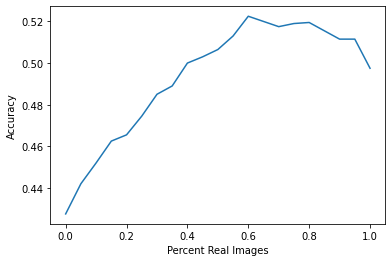

In [9]:
accuracies = []
p_real_all = torch.linspace(0, 1, 21)
for p_real_vis in tqdm(p_real_all):
    accuracies += [eval_augmentation(p_real_vis, best_gen_name, n_test=4)]
plt.plot(p_real_all.tolist(), accuracies)
plt.ylabel("Accuracy")
_ = plt.xlabel("Percent Real Images")

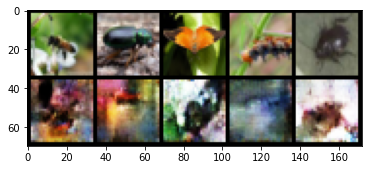

In [10]:
examples = [4, 41, 80, 122, 160]
train_images = torch.load("insect_train.pt")["images"][examples]
train_labels = torch.load("insect_train.pt")["labels"][examples]

one_hot_labels = get_one_hot_labels(train_labels.to(device), n_classes).float()
fake_noise = get_noise(len(train_images), z_dim, device=device)
noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
gen = Generator(generator_input_dim).to(device)
gen.load_state_dict(torch.load(best_gen_name))

fake = gen(noise_and_labels)
show_tensor_images(torch.cat([train_images.cpu(), fake.cpu()]))